# Peptides encoding (One-hot)

In [1]:
import peptides
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
from math import sqrt

# libs for ml
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
#from umap import UMAP

# my module with some func
import pepcode

## Preparing data

Set parameters: 

In [2]:
AA_LIST = pepcode.AA_LIST
AA_LIST = pepcode.AA_LIST

latent_dims = 200
num_epochs = 500 
batch_size = 1000
learning_rate = 1e-3 
use_gpu = True

# Device set
if use_gpu and torch.cuda.is_available():
    device = torch.device("cuda:0")
elif use_gpu and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

### Loading datasets

In [3]:
data = pd.read_csv('./dataset/vdjdb-2024-11-27-fixed/vdjdb.slim.txt', sep = '\t')
data = data[(data.gene == 'TRB') & (data.species == 'HomoSapiens')]
data.reset_index(drop=True, inplace=True)
index_list = []
for i in range(len(data)):
    if len(data.iloc[i].cdr3)==15 and data.iloc[i].cdr3[0]=='C' and (data.iloc[i].cdr3[-1]=='F' or data.iloc[i].cdr3[-1]=='W'):
        continue
    else:
        index_list.append(i)
data.drop(index=index_list, inplace=True)
data.reset_index(drop=True, inplace=True)
# data.sample(frac=1, random_state=100).reset_index(drop=True, inplace=True)
data = shuffle(data)

#Split dataset and prepare train, test, evaluation datasets
train_size, test_size, eval_size = int(round(len(data)*0.7, 0)), int(round(len(data)*(0.7+0.15), 0)), int(round(len(data)*(1), 0))
data_split = np.split(data, [train_size, test_size, eval_size], axis=0)
data_train = data_split[0]
data_test = data_split[1]
data_eval = data_split[2]

# Prepare peptide lists
pep_train_list = data_train.cdr3.values
pep_test_list = data_test.cdr3.values
pep_eval_list = data_eval.cdr3.values

len_seq = len(pep_train_list[0])


pep_train_oh = np.zeros((len(pep_train_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
for i in range(len(pep_train_oh)):
    pep_train_oh[i] = pepcode.one_hot_code(pep_train_list[i])

pep_test_oh = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
for i in range(len(pep_test_list)):
    pep_test_oh[i] = pepcode.one_hot_code(pep_test_list[i])   


oh_matr_size = pep_test_oh[0].size

# Пока не нужно
pep_eval_oh = np.zeros((len(pep_eval_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
for i in range(len(pep_eval_list)):
    pep_eval_oh[i] = pepcode.one_hot_code(pep_eval_list[i])  

# Prepare train dataloader
oh_dataset_train = torch.utils.data.TensorDataset(torch.tensor(pep_train_oh), torch.tensor(np.ones(pep_train_oh.shape[0])))
oh_dl_train = torch.utils.data.DataLoader(oh_dataset_train, batch_size=batch_size, shuffle=False)

# Prepare test dataloader
oh_dataset_test = torch.utils.data.TensorDataset(torch.tensor(pep_test_oh), torch.tensor(np.ones(pep_test_oh.shape[0])))
oh_dl_test= torch.utils.data.DataLoader(oh_dataset_test, batch_size=batch_size, shuffle=False)

# Evaluation (пока не нужно)
oh_dataset_eval = torch.utils.data.TensorDataset(torch.tensor(pep_eval_oh), torch.tensor(np.ones(pep_eval_oh.shape[0])))
oh_eval_dl = torch.utils.data.DataLoader(oh_dataset_eval, batch_size=batch_size, shuffle=False)


/Users/alex/miniconda3/envs/tcreppred_sil2/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


## Autoencoder_1 definition (300->50)

In [4]:
numb = 1
autoencoder_arch = '300->50 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=50)
            
    def forward(self, x):
        x = self.fc1(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=50, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 30350


### Train autoencoder

In [5]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.242794
Epoch [11 / 500] average reconstruction error: 0.030115
Epoch [21 / 500] average reconstruction error: 0.028434
Epoch [31 / 500] average reconstruction error: 0.026553
Epoch [41 / 500] average reconstruction error: 0.024021
Epoch [51 / 500] average reconstruction error: 0.021340
Epoch [61 / 500] average reconstruction error: 0.019241
Epoch [71 / 500] average reconstruction error: 0.017685
Epoch [81 / 500] average reconstruction error: 0.016461
Epoch [91 / 500] average reconstruction error: 0.015411
Epoch [101 / 500] average reconstruction error: 0.014473
Epoch [111 / 500] average reconstruction error: 0.013589
Epoch [121 / 500] average reconstruction error: 0.012722
Epoch [131 / 500] average reconstruction error: 0.011869
Epoch [141 / 500] average reconstruction error: 0.011043
Epoch [151 / 500] average reconstruction error: 0.010271
Epoch [161 / 500] average reconstruction error: 0.009559
Epoch [171 / 500] average rec

### Evaluation

In [6]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.001007


### Biological evaluatiuon

In [7]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

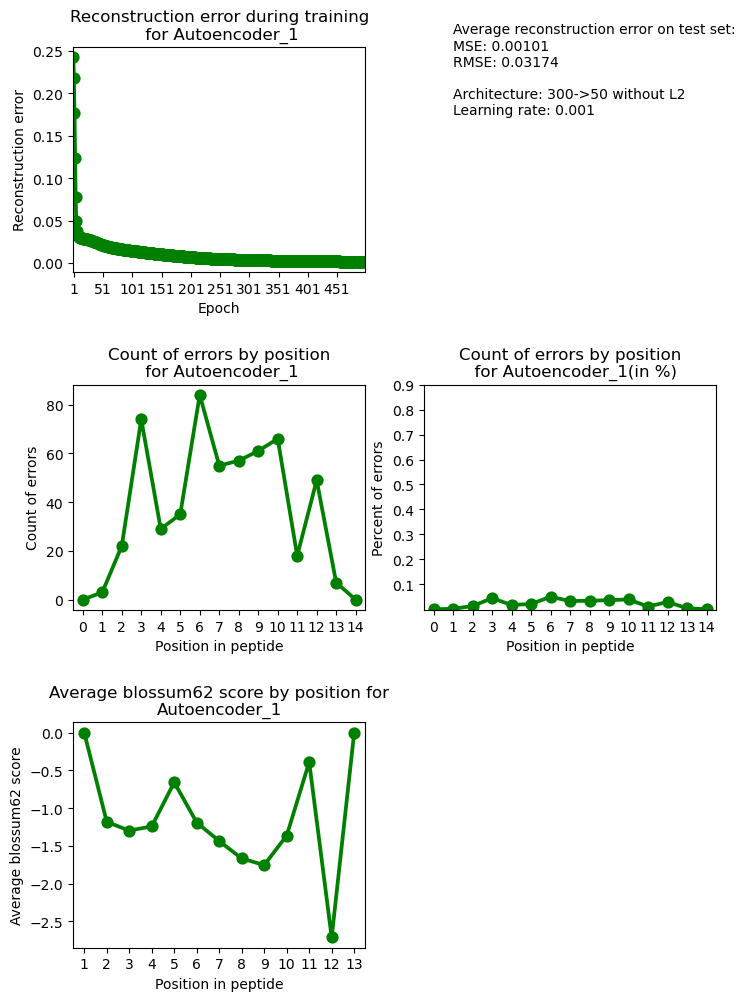

In [8]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_2 definition (300->100)

In [9]:
numb += 1
autoencoder_arch = '300->100 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=100)
            
    def forward(self, x):
        x = self.fc1(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=100, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 60400


### Train autoencoder

In [10]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.239379
Epoch [11 / 500] average reconstruction error: 0.028764
Epoch [21 / 500] average reconstruction error: 0.026219
Epoch [31 / 500] average reconstruction error: 0.022781
Epoch [41 / 500] average reconstruction error: 0.019438
Epoch [51 / 500] average reconstruction error: 0.017004
Epoch [61 / 500] average reconstruction error: 0.015228
Epoch [71 / 500] average reconstruction error: 0.013770
Epoch [81 / 500] average reconstruction error: 0.012392
Epoch [91 / 500] average reconstruction error: 0.011045
Epoch [101 / 500] average reconstruction error: 0.009796
Epoch [111 / 500] average reconstruction error: 0.008689
Epoch [121 / 500] average reconstruction error: 0.007710
Epoch [131 / 500] average reconstruction error: 0.006802
Epoch [141 / 500] average reconstruction error: 0.005986
Epoch [151 / 500] average reconstruction error: 0.005311
Epoch [161 / 500] average reconstruction error: 0.004759
Epoch [171 / 500] average rec

### Evaluation

In [11]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.000239


### Biological evaluatiuon

In [12]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

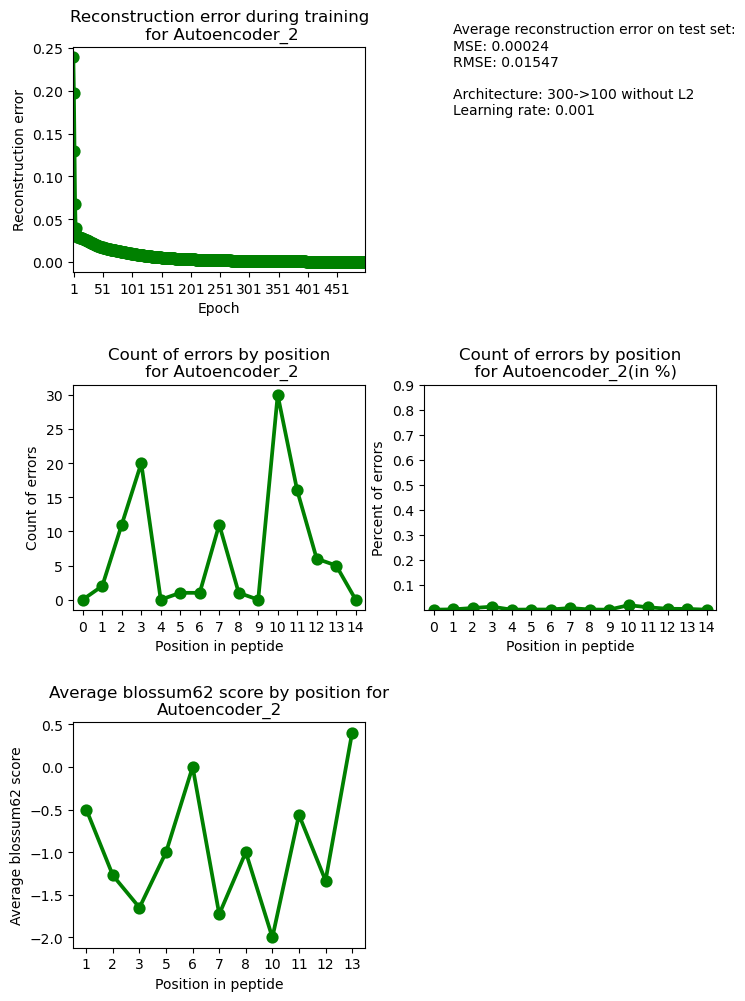

In [13]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_3 definition (300->200)

In [14]:
numb += 1
autoencoder_arch = '300->200 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=200)
            
    def forward(self, x):
        x = self.fc1(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=200, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 120500


### Train autoencoder

In [15]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.231203
Epoch [11 / 500] average reconstruction error: 0.027546
Epoch [21 / 500] average reconstruction error: 0.022589
Epoch [31 / 500] average reconstruction error: 0.017698
Epoch [41 / 500] average reconstruction error: 0.014613
Epoch [51 / 500] average reconstruction error: 0.012151
Epoch [61 / 500] average reconstruction error: 0.010054
Epoch [71 / 500] average reconstruction error: 0.008358
Epoch [81 / 500] average reconstruction error: 0.006858
Epoch [91 / 500] average reconstruction error: 0.005575
Epoch [101 / 500] average reconstruction error: 0.004587
Epoch [111 / 500] average reconstruction error: 0.003876
Epoch [121 / 500] average reconstruction error: 0.003381
Epoch [131 / 500] average reconstruction error: 0.002984
Epoch [141 / 500] average reconstruction error: 0.002645
Epoch [151 / 500] average reconstruction error: 0.002379
Epoch [161 / 500] average reconstruction error: 0.002164
Epoch [171 / 500] average rec

### Evaluation

In [16]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.000129


### Biological evaluatiuon

In [17]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

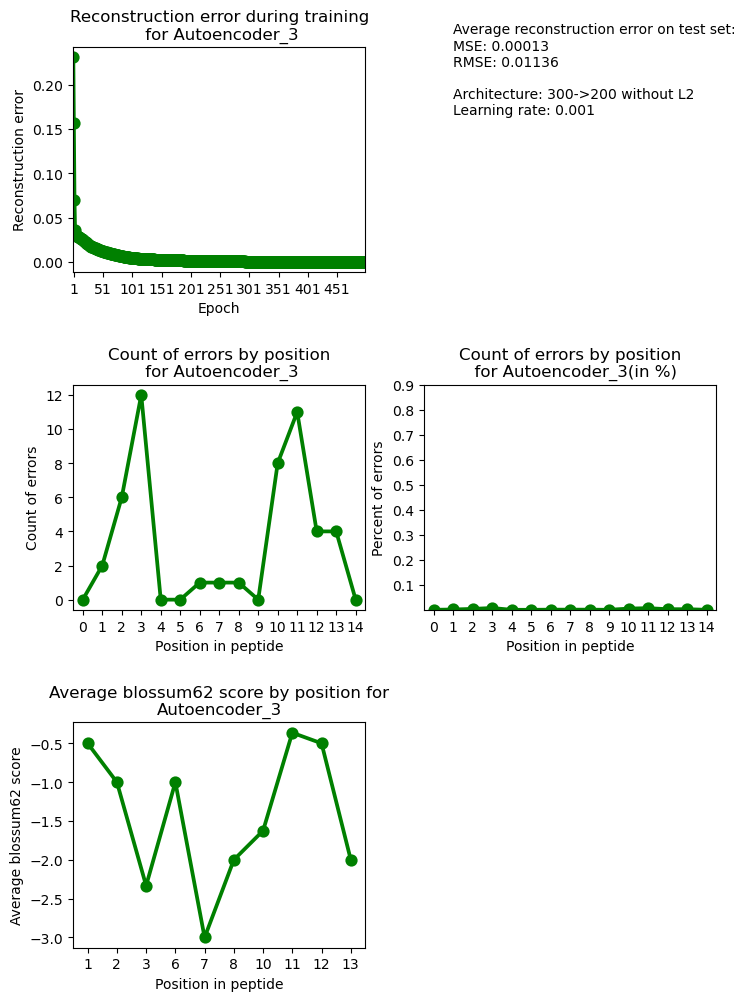

In [18]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_4 definition (300->300)

In [19]:
numb += 1
autoencoder_arch = '300->300 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=300)
            
    def forward(self, x):
        x = self.fc1(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=300, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 180600


### Train autoencoder

In [20]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.224934
Epoch [11 / 500] average reconstruction error: 0.026396
Epoch [21 / 500] average reconstruction error: 0.019594
Epoch [31 / 500] average reconstruction error: 0.014921
Epoch [41 / 500] average reconstruction error: 0.011649
Epoch [51 / 500] average reconstruction error: 0.009053
Epoch [61 / 500] average reconstruction error: 0.007014
Epoch [71 / 500] average reconstruction error: 0.005339
Epoch [81 / 500] average reconstruction error: 0.004220
Epoch [91 / 500] average reconstruction error: 0.003473
Epoch [101 / 500] average reconstruction error: 0.002918
Epoch [111 / 500] average reconstruction error: 0.002514
Epoch [121 / 500] average reconstruction error: 0.002215
Epoch [131 / 500] average reconstruction error: 0.001953
Epoch [141 / 500] average reconstruction error: 0.001731
Epoch [151 / 500] average reconstruction error: 0.001522
Epoch [161 / 500] average reconstruction error: 0.001304
Epoch [171 / 500] average rec

### Evaluation

In [21]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.000093


### Biological evaluatiuon

In [22]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

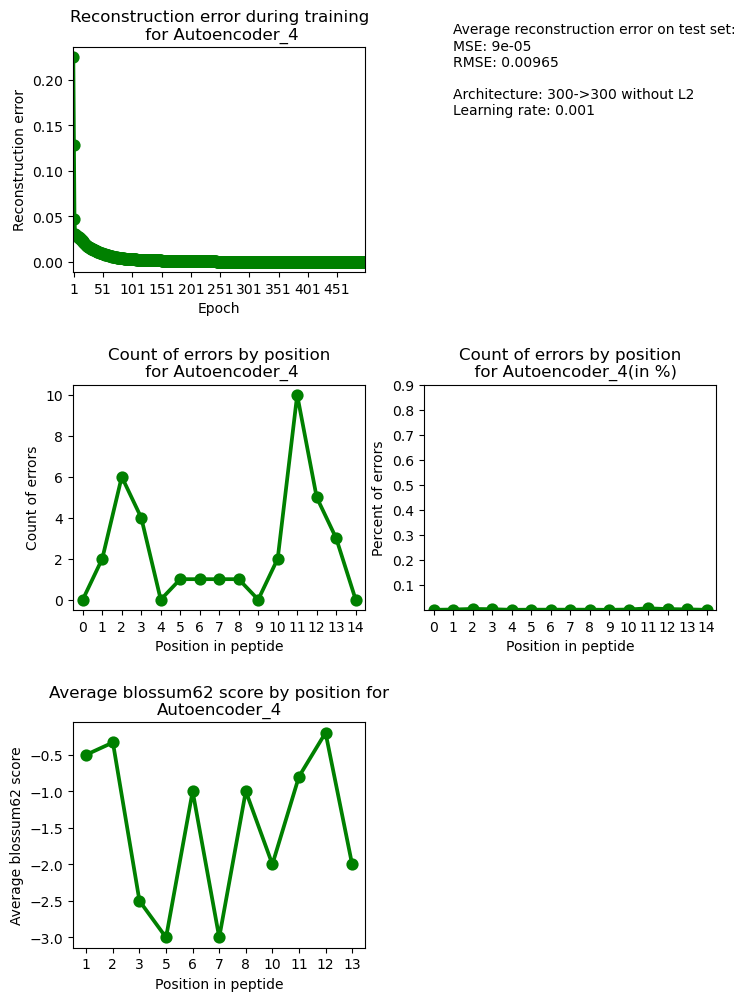

In [23]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_5 definition (300->700->200)

In [24]:
numb += 1
autoencoder_arch = '300->700->200 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=700)
        self.fc2 = nn.Linear(in_features=700, out_features=200)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=200, out_features=700)
        self.fc2 = nn.Linear(in_features=700, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 701900


### Train autoencoder

In [25]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.179024
Epoch [11 / 500] average reconstruction error: 0.028879
Epoch [21 / 500] average reconstruction error: 0.026570
Epoch [31 / 500] average reconstruction error: 0.026435
Epoch [41 / 500] average reconstruction error: 0.026429
Epoch [51 / 500] average reconstruction error: 0.026427
Epoch [61 / 500] average reconstruction error: 0.026426
Epoch [71 / 500] average reconstruction error: 0.026426
Epoch [81 / 500] average reconstruction error: 0.026426
Epoch [91 / 500] average reconstruction error: 0.026425
Epoch [101 / 500] average reconstruction error: 0.026425
Epoch [111 / 500] average reconstruction error: 0.026425
Epoch [121 / 500] average reconstruction error: 0.026425
Epoch [131 / 500] average reconstruction error: 0.026425
Epoch [141 / 500] average reconstruction error: 0.026425
Epoch [151 / 500] average reconstruction error: 0.026425
Epoch [161 / 500] average reconstruction error: 0.026425
Epoch [171 / 500] average rec

### Evaluation

In [26]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.013204


### Biological evaluatiuon

In [27]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

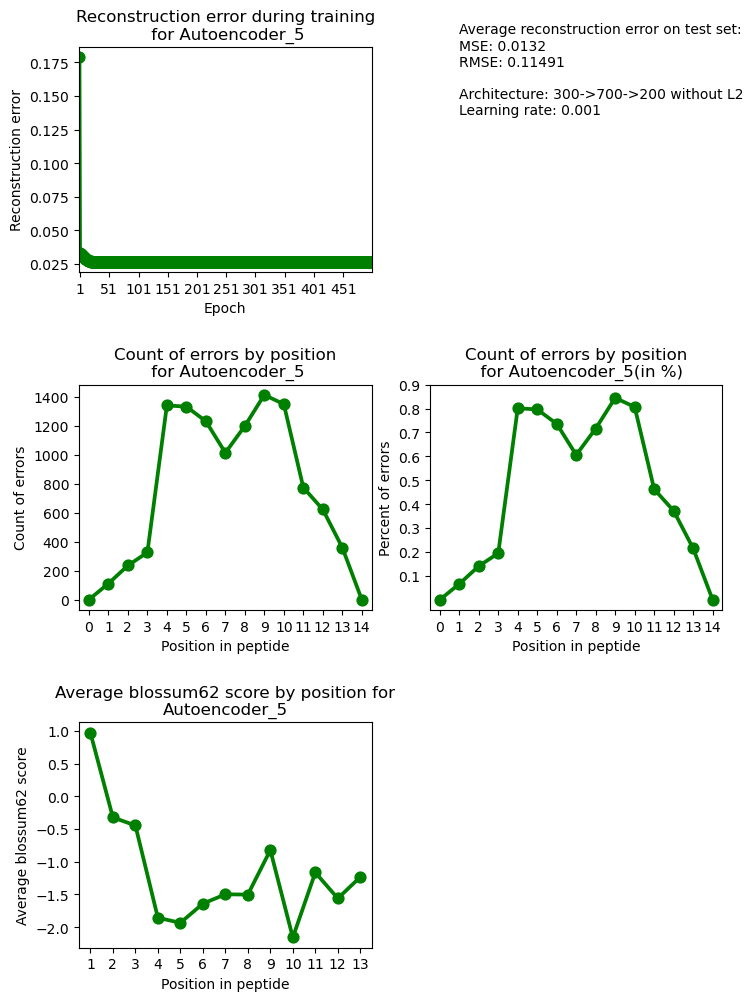

In [28]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_6 definition (300->200->100)

In [29]:
numb += 1
autoencoder_arch = '300->200->100 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=200)
        self.fc2 = nn.Linear(in_features=200, out_features=100)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=100, out_features=200)
        self.fc2 = nn.Linear(in_features=200, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 160800


### Train autoencoder

In [30]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.234620
Epoch [11 / 500] average reconstruction error: 0.031073
Epoch [21 / 500] average reconstruction error: 0.027437
Epoch [31 / 500] average reconstruction error: 0.025208
Epoch [41 / 500] average reconstruction error: 0.022920
Epoch [51 / 500] average reconstruction error: 0.021031
Epoch [61 / 500] average reconstruction error: 0.019901
Epoch [71 / 500] average reconstruction error: 0.019194
Epoch [81 / 500] average reconstruction error: 0.018821
Epoch [91 / 500] average reconstruction error: 0.018339
Epoch [101 / 500] average reconstruction error: 0.018024
Epoch [111 / 500] average reconstruction error: 0.017905
Epoch [121 / 500] average reconstruction error: 0.017637
Epoch [131 / 500] average reconstruction error: 0.017584
Epoch [141 / 500] average reconstruction error: 0.017551
Epoch [151 / 500] average reconstruction error: 0.017497
Epoch [161 / 500] average reconstruction error: 0.017458
Epoch [171 / 500] average rec

### Evaluation

In [31]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.008049


### Biological evaluatiuon

In [32]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

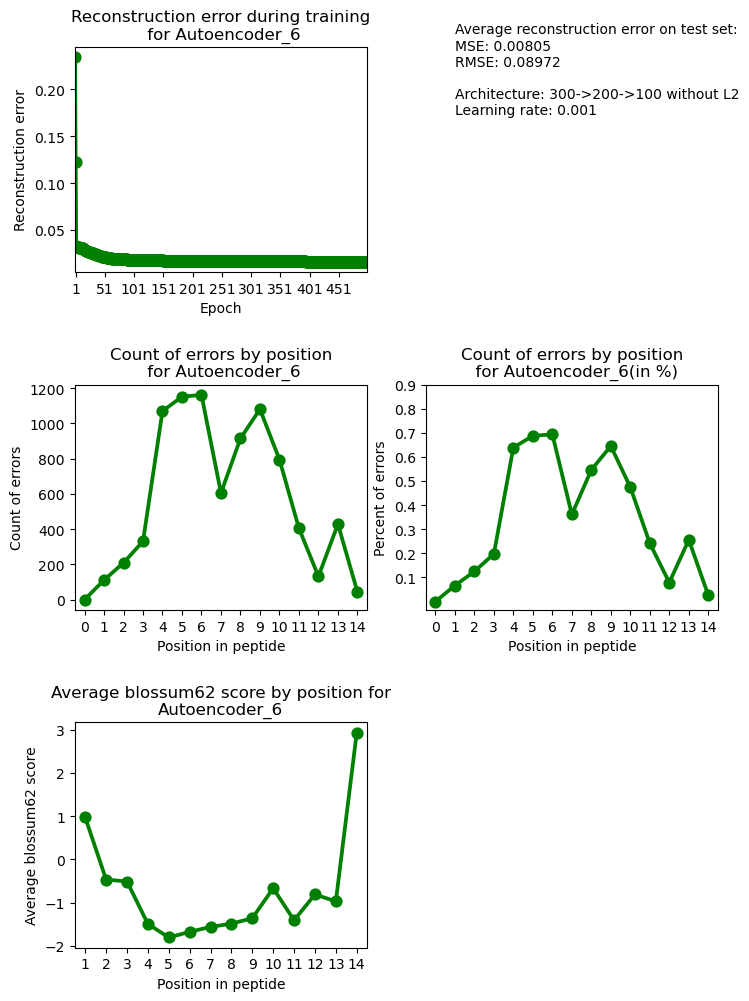

In [33]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_7 definition (300->800->600->200)

In [34]:
numb += 1
autoencoder_arch = '300->800->600->200 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=800)
        self.fc2 = nn.Linear(in_features=800, out_features=600)
        self.fc3 = nn.Linear(in_features=600, out_features=200)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=200, out_features=600)
        self.fc2 = nn.Linear(in_features=600, out_features=800)
        self.fc3 = nn.Linear(in_features=800, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 1683300


### Train autoencoder

In [35]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.158257
Epoch [11 / 500] average reconstruction error: 0.035920
Epoch [21 / 500] average reconstruction error: 0.035920
Epoch [31 / 500] average reconstruction error: 0.035920
Epoch [41 / 500] average reconstruction error: 0.035920
Epoch [51 / 500] average reconstruction error: 0.035920
Epoch [61 / 500] average reconstruction error: 0.035920
Epoch [71 / 500] average reconstruction error: 0.035920
Epoch [81 / 500] average reconstruction error: 0.035920
Epoch [91 / 500] average reconstruction error: 0.035920
Epoch [101 / 500] average reconstruction error: 0.035920
Epoch [111 / 500] average reconstruction error: 0.035920
Epoch [121 / 500] average reconstruction error: 0.035920
Epoch [131 / 500] average reconstruction error: 0.035920
Epoch [141 / 500] average reconstruction error: 0.035920
Epoch [151 / 500] average reconstruction error: 0.035920
Epoch [161 / 500] average reconstruction error: 0.035920
Epoch [171 / 500] average rec

### Evaluation

In [36]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.017905


### Biological evaluatiuon

In [37]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

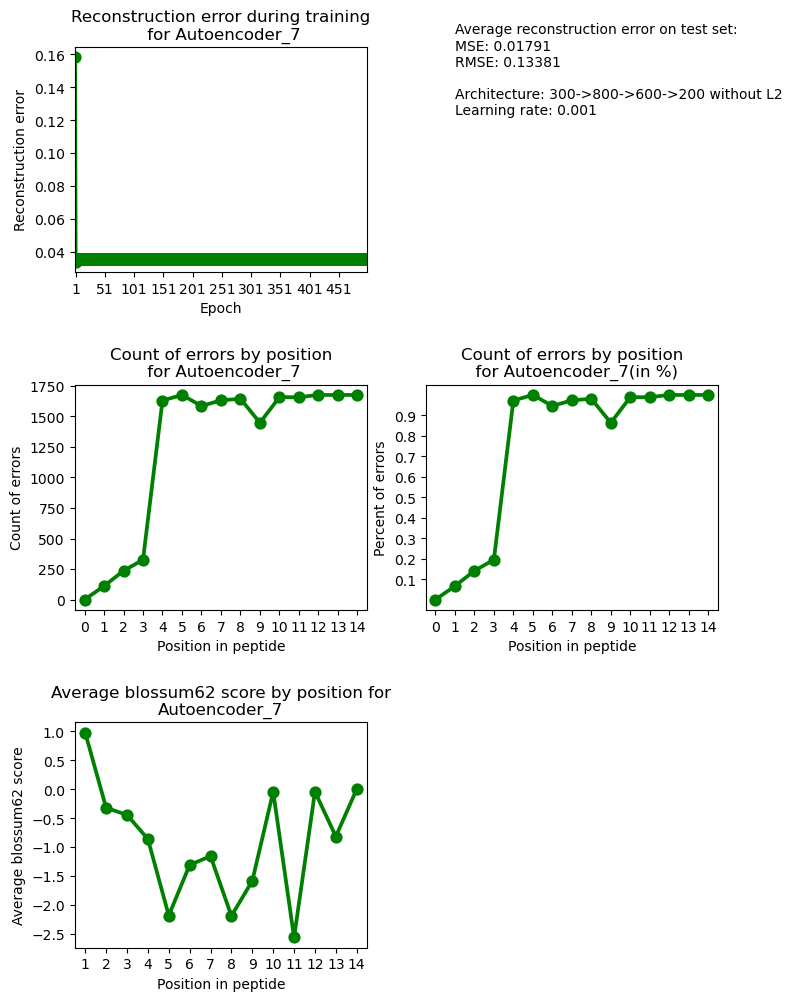

In [38]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_8 definition (300->500D->100)

In [39]:
numb += 1
autoencoder_arch = '300->500D->100 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=100)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.dropout(x, p=0.2)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=100, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 401400


### Train autoencoder

In [40]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.208061
Epoch [11 / 500] average reconstruction error: 0.029979
Epoch [21 / 500] average reconstruction error: 0.027354
Epoch [31 / 500] average reconstruction error: 0.026509
Epoch [41 / 500] average reconstruction error: 0.026455
Epoch [51 / 500] average reconstruction error: 0.026440
Epoch [61 / 500] average reconstruction error: 0.026520
Epoch [71 / 500] average reconstruction error: 0.026433
Epoch [81 / 500] average reconstruction error: 0.026431
Epoch [91 / 500] average reconstruction error: 0.026430
Epoch [101 / 500] average reconstruction error: 0.026428
Epoch [111 / 500] average reconstruction error: 0.026428
Epoch [121 / 500] average reconstruction error: 0.026427
Epoch [131 / 500] average reconstruction error: 0.026427
Epoch [141 / 500] average reconstruction error: 0.026426
Epoch [151 / 500] average reconstruction error: 0.026426
Epoch [161 / 500] average reconstruction error: 0.026426
Epoch [171 / 500] average rec

### Evaluation

In [41]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.013204


### Biological evaluatiuon

In [42]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

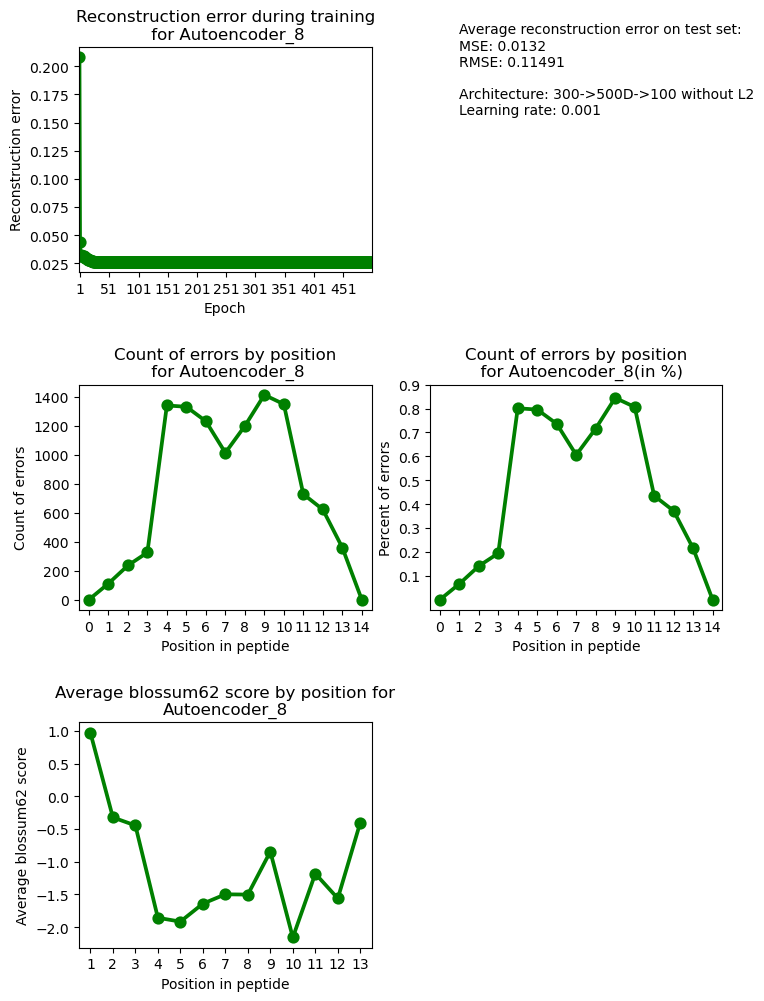

In [43]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_9 definition (300->2000->1000->200)

In [44]:
numb += 1
autoencoder_arch = '300->2000->1000->200 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=2000)
        self.fc2 = nn.Linear(in_features=2000, out_features=1000)
        self.fc3 = nn.Linear(in_features=1000, out_features=200)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=200, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=2000)
        self.fc3 = nn.Linear(in_features=2000, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 5606500


### Train autoencoder

In [45]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.111088
Epoch [11 / 500] average reconstruction error: 0.037944
Epoch [21 / 500] average reconstruction error: 0.037953
Epoch [31 / 500] average reconstruction error: 0.037944
Epoch [41 / 500] average reconstruction error: 0.037944
Epoch [51 / 500] average reconstruction error: 0.037944
Epoch [61 / 500] average reconstruction error: 0.037944
Epoch [71 / 500] average reconstruction error: 0.037944
Epoch [81 / 500] average reconstruction error: 0.037944
Epoch [91 / 500] average reconstruction error: 0.037944
Epoch [101 / 500] average reconstruction error: 0.037944
Epoch [111 / 500] average reconstruction error: 0.037944
Epoch [121 / 500] average reconstruction error: 0.037944
Epoch [131 / 500] average reconstruction error: 0.037944
Epoch [141 / 500] average reconstruction error: 0.037944
Epoch [151 / 500] average reconstruction error: 0.037944
Epoch [161 / 500] average reconstruction error: 0.037944
Epoch [171 / 500] average rec

### Evaluation

In [46]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.018938


### Biological evaluatiuon

In [47]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

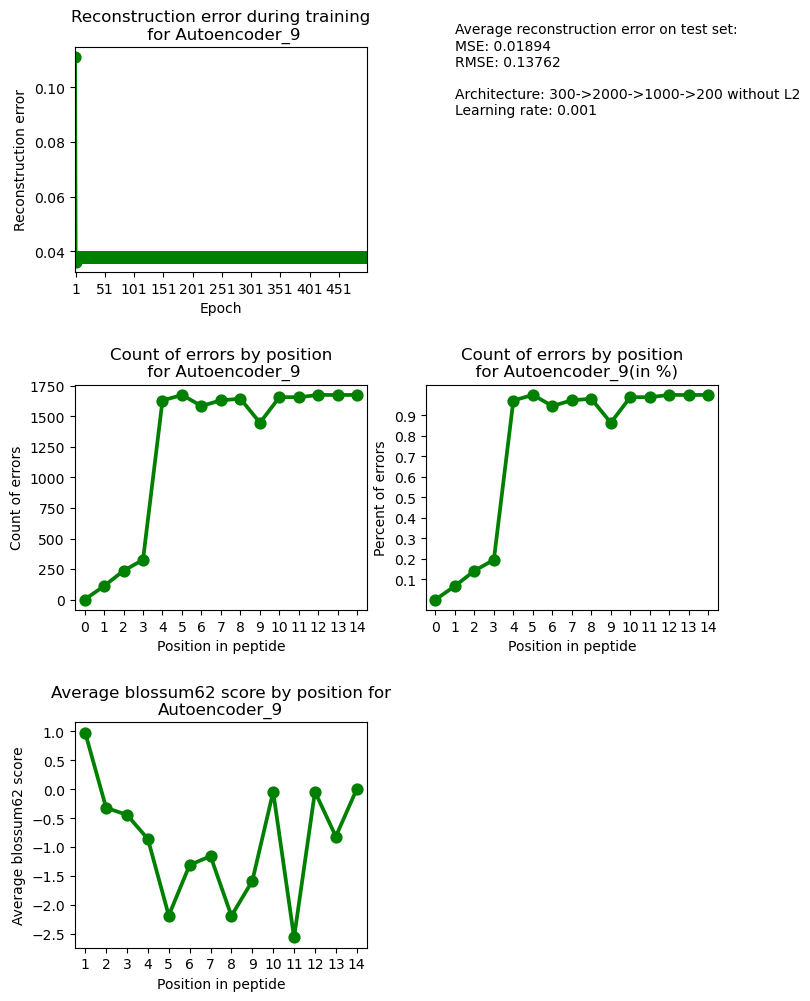

In [48]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_10 definition (300->2000->200)

In [49]:
numb += 1
autoencoder_arch = '300->2000->200 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=2000)
        self.fc2 = nn.Linear(in_features=2000, out_features=200)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=200, out_features=2000)
        self.fc2 = nn.Linear(in_features=2000, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 2004500


### Train autoencoder

In [50]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.112589
Epoch [11 / 500] average reconstruction error: 0.030282
Epoch [21 / 500] average reconstruction error: 0.029844
Epoch [31 / 500] average reconstruction error: 0.029840
Epoch [41 / 500] average reconstruction error: 0.029840
Epoch [51 / 500] average reconstruction error: 0.029840
Epoch [61 / 500] average reconstruction error: 0.029840
Epoch [71 / 500] average reconstruction error: 0.029840
Epoch [81 / 500] average reconstruction error: 0.029840
Epoch [91 / 500] average reconstruction error: 0.029840
Epoch [101 / 500] average reconstruction error: 0.029840
Epoch [111 / 500] average reconstruction error: 0.029840
Epoch [121 / 500] average reconstruction error: 0.029840
Epoch [131 / 500] average reconstruction error: 0.029840
Epoch [141 / 500] average reconstruction error: 0.029308
Epoch [151 / 500] average reconstruction error: 0.027411
Epoch [161 / 500] average reconstruction error: 0.027402
Epoch [171 / 500] average rec

### Evaluation

In [51]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.013343


### Biological evaluatiuon

In [52]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

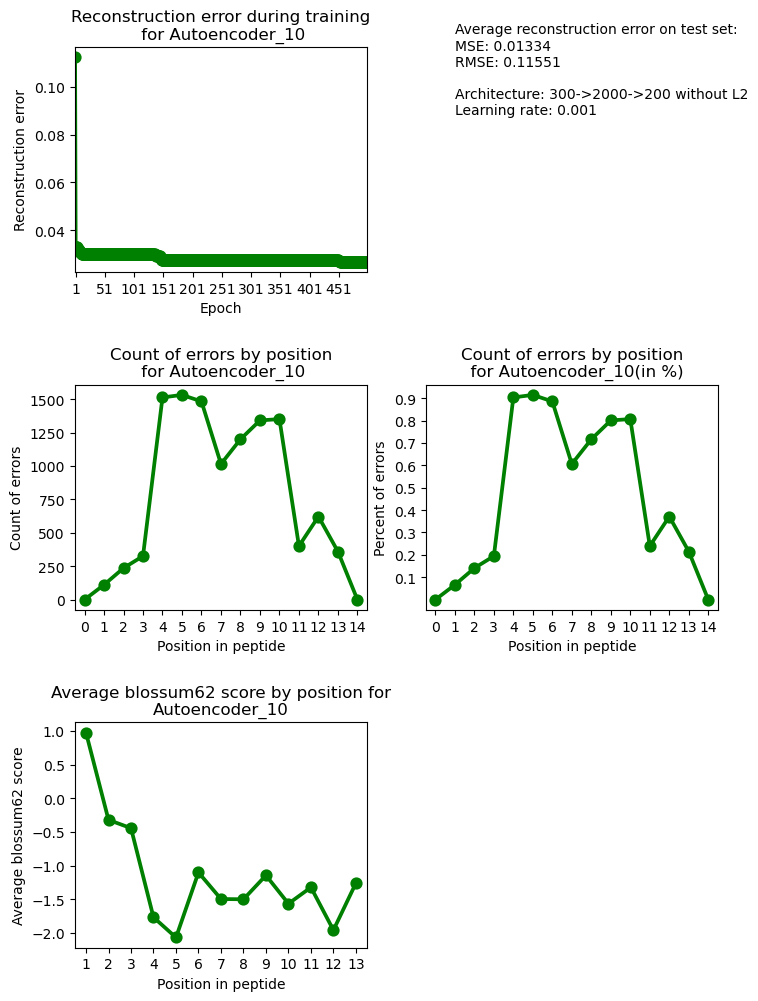

In [53]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_11 definition (300->700->200)

In [54]:
numb += 1
learning_rate = 0.0001
autoencoder_arch = '300->700->200 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=700)
        self.fc2 = nn.Linear(in_features=700, out_features=200)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=200, out_features=700)
        self.fc2 = nn.Linear(in_features=700, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 701900


### Train autoencoder

In [55]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.247947
Epoch [11 / 500] average reconstruction error: 0.030159
Epoch [21 / 500] average reconstruction error: 0.029213
Epoch [31 / 500] average reconstruction error: 0.028987
Epoch [41 / 500] average reconstruction error: 0.028566
Epoch [51 / 500] average reconstruction error: 0.027060
Epoch [61 / 500] average reconstruction error: 0.025339
Epoch [71 / 500] average reconstruction error: 0.023012
Epoch [81 / 500] average reconstruction error: 0.021082
Epoch [91 / 500] average reconstruction error: 0.019550
Epoch [101 / 500] average reconstruction error: 0.018034
Epoch [111 / 500] average reconstruction error: 0.016635
Epoch [121 / 500] average reconstruction error: 0.015420
Epoch [131 / 500] average reconstruction error: 0.014521
Epoch [141 / 500] average reconstruction error: 0.013815
Epoch [151 / 500] average reconstruction error: 0.013135
Epoch [161 / 500] average reconstruction error: 0.012574
Epoch [171 / 500] average rec

### Evaluation

In [56]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.001572


### Biological evaluatiuon

In [57]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

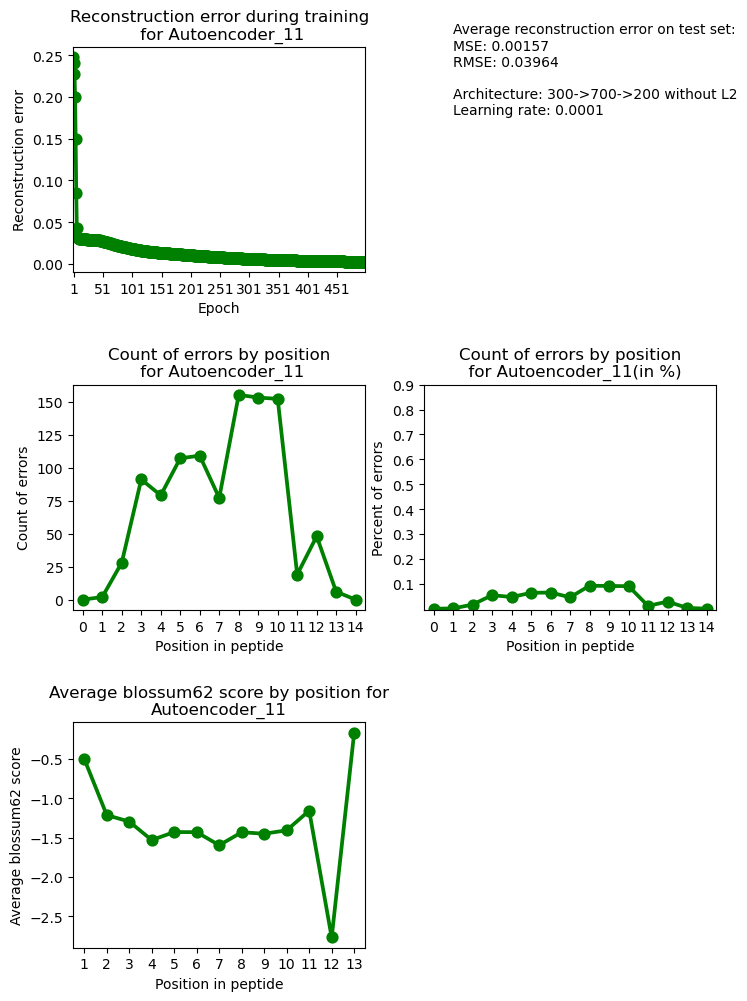

In [58]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_12 definition (300->700->200)

In [59]:
numb += 1
learning_rate = 0.01
autoencoder_arch = '300->700->200 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=700)
        self.fc2 = nn.Linear(in_features=700, out_features=200)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=200, out_features=700)
        self.fc2 = nn.Linear(in_features=700, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 701900


### Train autoencoder

In [60]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.068085
Epoch [11 / 500] average reconstruction error: 0.037519
Epoch [21 / 500] average reconstruction error: 0.037519
Epoch [31 / 500] average reconstruction error: 0.037519
Epoch [41 / 500] average reconstruction error: 0.037519
Epoch [51 / 500] average reconstruction error: 0.037519
Epoch [61 / 500] average reconstruction error: 0.037519
Epoch [71 / 500] average reconstruction error: 0.037519
Epoch [81 / 500] average reconstruction error: 0.037519
Epoch [91 / 500] average reconstruction error: 0.037519
Epoch [101 / 500] average reconstruction error: 0.037519
Epoch [111 / 500] average reconstruction error: 0.037519
Epoch [121 / 500] average reconstruction error: 0.037519
Epoch [131 / 500] average reconstruction error: 0.037519
Epoch [141 / 500] average reconstruction error: 0.037519
Epoch [151 / 500] average reconstruction error: 0.037519
Epoch [161 / 500] average reconstruction error: 0.037519
Epoch [171 / 500] average rec

### Evaluation

In [61]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.018724


### Biological evaluatiuon

In [62]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

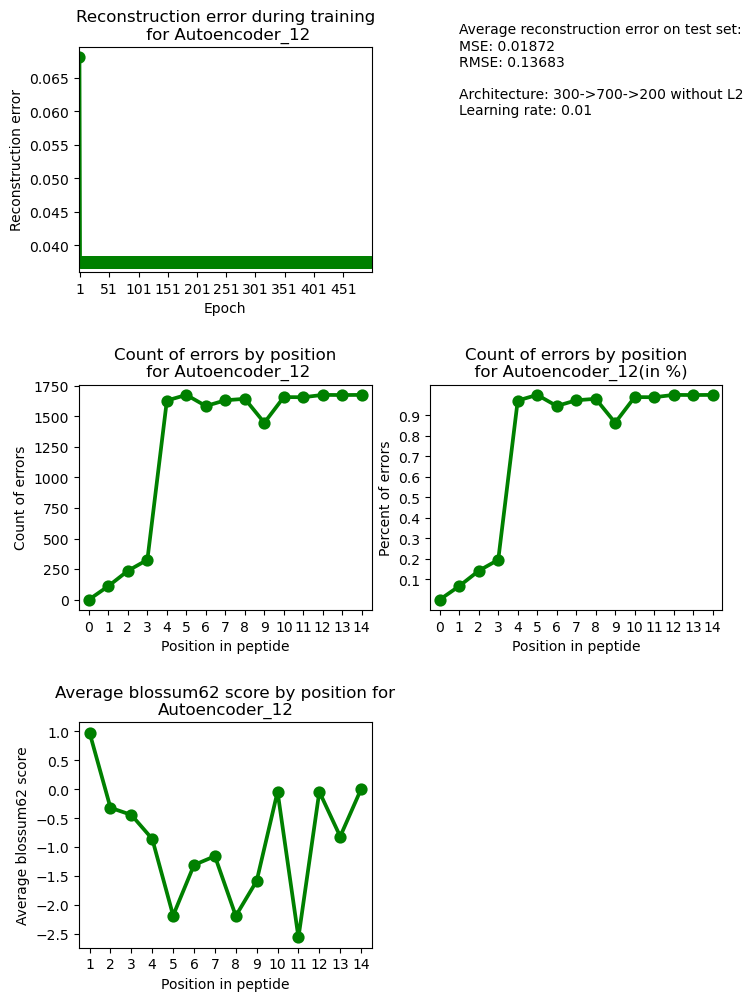

In [63]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_13 definition (300->700->200) without L2

In [64]:
numb += 1
learning_rate = 1e-3
autoencoder_arch = '300->700->200 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=700)
        self.fc2 = nn.Linear(in_features=700, out_features=200)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=200, out_features=700)
        self.fc2 = nn.Linear(in_features=700, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 701900


### Train autoencoder

In [65]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.184820
Epoch [11 / 500] average reconstruction error: 0.028701
Epoch [21 / 500] average reconstruction error: 0.026505
Epoch [31 / 500] average reconstruction error: 0.026433
Epoch [41 / 500] average reconstruction error: 0.026428
Epoch [51 / 500] average reconstruction error: 0.026426
Epoch [61 / 500] average reconstruction error: 0.026426
Epoch [71 / 500] average reconstruction error: 0.026425
Epoch [81 / 500] average reconstruction error: 0.026425
Epoch [91 / 500] average reconstruction error: 0.026425
Epoch [101 / 500] average reconstruction error: 0.026425
Epoch [111 / 500] average reconstruction error: 0.026425
Epoch [121 / 500] average reconstruction error: 0.026425
Epoch [131 / 500] average reconstruction error: 0.026425
Epoch [141 / 500] average reconstruction error: 0.026425
Epoch [151 / 500] average reconstruction error: 0.026425
Epoch [161 / 500] average reconstruction error: 0.026425
Epoch [171 / 500] average rec

### Evaluation

In [66]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.010923


### Biological evaluatiuon

In [67]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

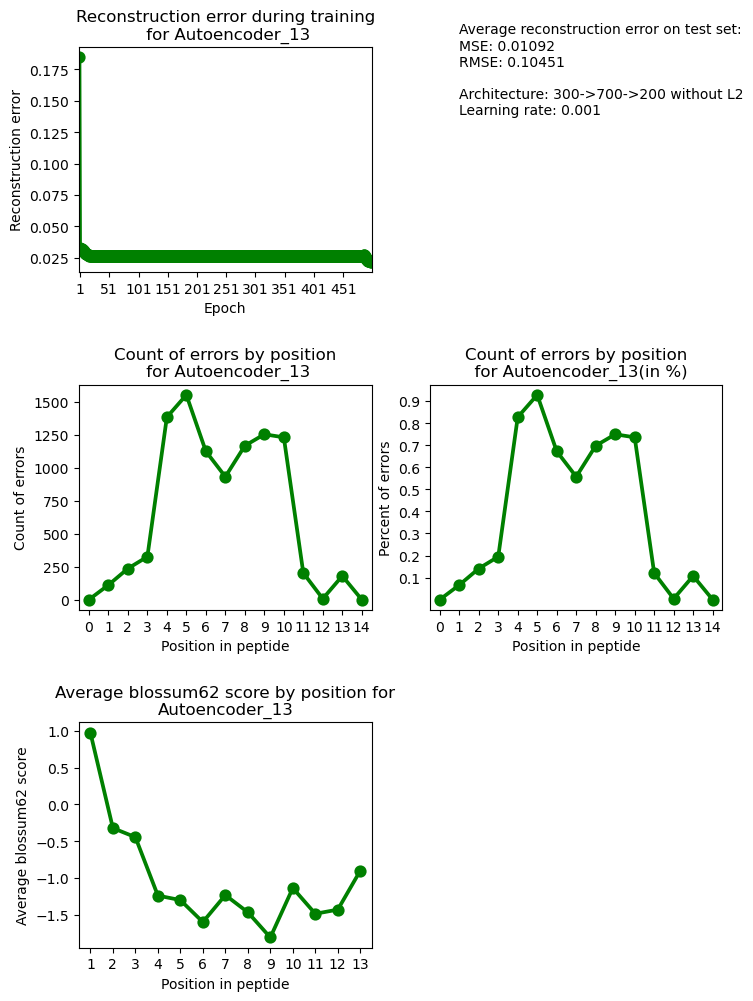

In [68]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_14 definition (300->700->200) with big L2

In [69]:
numb += 1
learning_rate = 1e-3
autoencoder_arch = '300->700->200 with big L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=700)
        self.fc2 = nn.Linear(in_features=700, out_features=200)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=200, out_features=700)
        self.fc2 = nn.Linear(in_features=700, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate,  weight_decay = 1e-2)

Number of parameters for One-hot encoding: 701900


### Train autoencoder

In [70]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.247486
Epoch [11 / 500] average reconstruction error: 0.038047
Epoch [21 / 500] average reconstruction error: 0.037914
Epoch [31 / 500] average reconstruction error: 0.037899
Epoch [41 / 500] average reconstruction error: 0.037899
Epoch [51 / 500] average reconstruction error: 0.037901
Epoch [61 / 500] average reconstruction error: 0.037902
Epoch [71 / 500] average reconstruction error: 0.037902
Epoch [81 / 500] average reconstruction error: 0.037903
Epoch [91 / 500] average reconstruction error: 0.037904
Epoch [101 / 500] average reconstruction error: 0.037905
Epoch [111 / 500] average reconstruction error: 0.037906
Epoch [121 / 500] average reconstruction error: 0.037907
Epoch [131 / 500] average reconstruction error: 0.037909
Epoch [141 / 500] average reconstruction error: 0.037911
Epoch [151 / 500] average reconstruction error: 0.037912
Epoch [161 / 500] average reconstruction error: 0.037912
Epoch [171 / 500] average rec

### Evaluation

In [71]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.019036


### Biological evaluatiuon

In [72]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

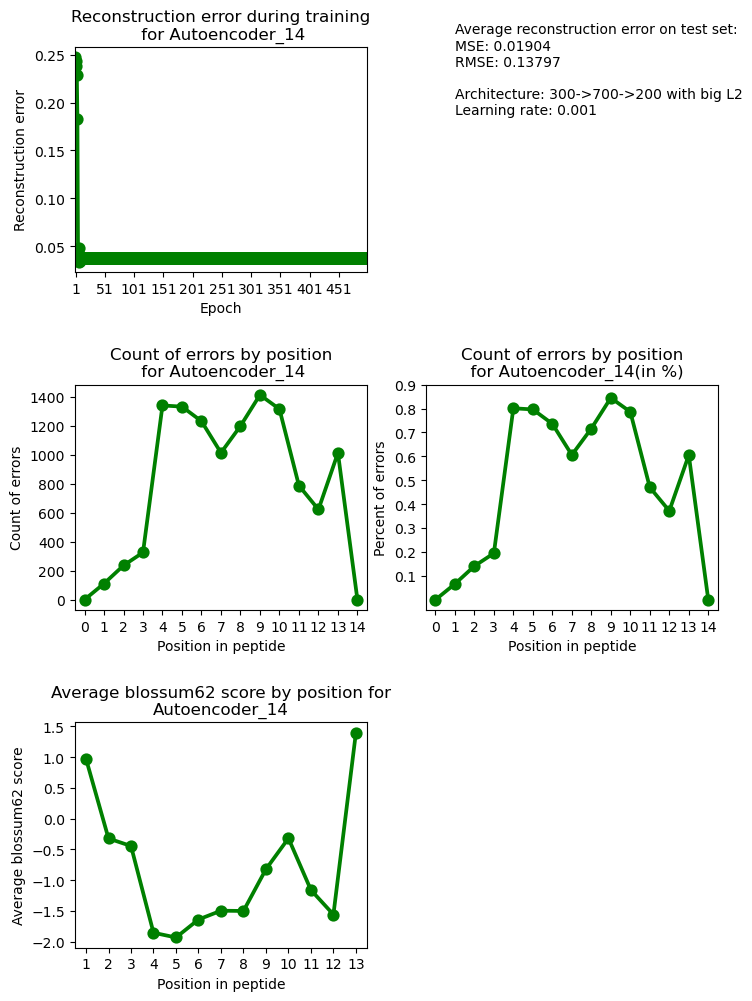

In [73]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_15 definition (300->700->200) without L2 sigmoid

In [74]:
numb = 15
learning_rate = 1e-3
autoencoder_arch = '300->700->200 without L2 sigmoid'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=700)
        self.fc2 = nn.Linear(in_features=700, out_features=200)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=200, out_features=700)
        self.fc2 = nn.Linear(in_features=700, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 701900


### Train autoencoder

In [75]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.098166
Epoch [11 / 500] average reconstruction error: 0.030203
Epoch [21 / 500] average reconstruction error: 0.029678
Epoch [31 / 500] average reconstruction error: 0.029347
Epoch [41 / 500] average reconstruction error: 0.026150
Epoch [51 / 500] average reconstruction error: 0.023713
Epoch [61 / 500] average reconstruction error: 0.022054
Epoch [71 / 500] average reconstruction error: 0.021015
Epoch [81 / 500] average reconstruction error: 0.020345
Epoch [91 / 500] average reconstruction error: 0.019867
Epoch [101 / 500] average reconstruction error: 0.019519
Epoch [111 / 500] average reconstruction error: 0.019218
Epoch [121 / 500] average reconstruction error: 0.018913
Epoch [131 / 500] average reconstruction error: 0.018573
Epoch [141 / 500] average reconstruction error: 0.018151
Epoch [151 / 500] average reconstruction error: 0.017484
Epoch [161 / 500] average reconstruction error: 0.016762
Epoch [171 / 500] average rec

### Evaluation

In [76]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.002878


### Biological evaluatiuon

In [77]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

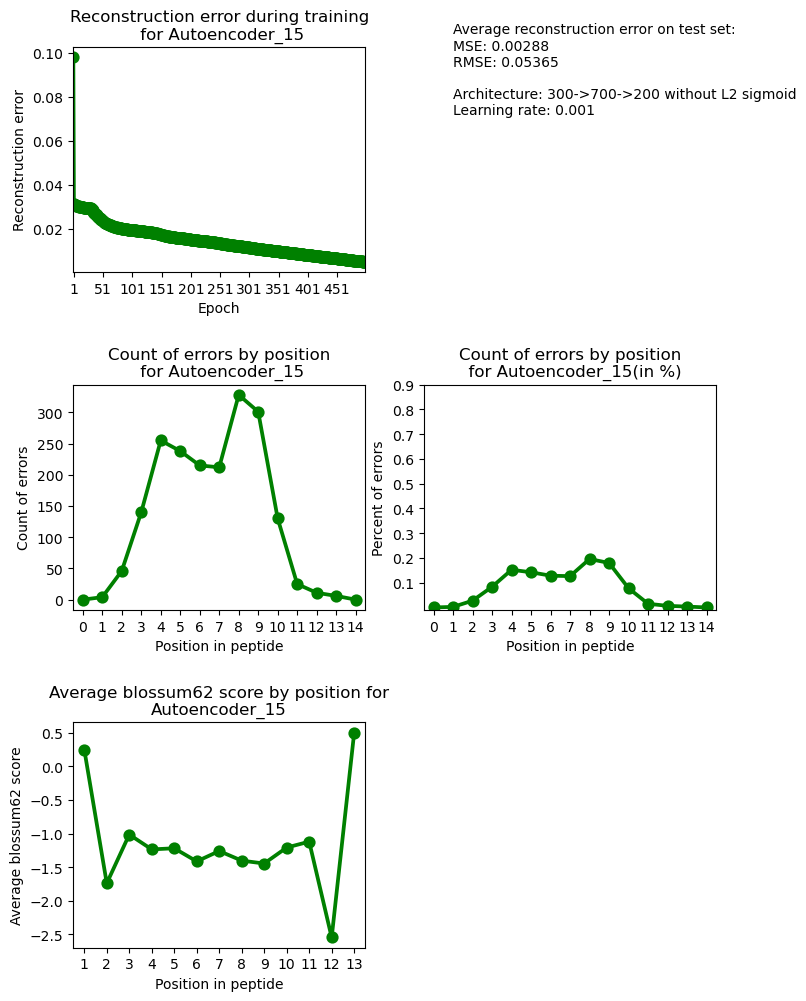

In [78]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')
